# The main algorithm for regression in PEST is the Gauss-Levenberg-Marquardt (GLM)  algorithm



In [1]:
%matplotlib inline
import os
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu

import xsect_setup
import response_surface as resurf

copy the model files over

In [2]:
xsect_setup.setup_model()

In [3]:
working_dir = xsect_setup.WORKING_DIR
pst_name = xsect_setup.PST_NAME

## Let's open up the `PST` file and check out the parameters

In [4]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))

In [5]:
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
hk1,hk1,log,factor,2.5,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
cal_flux,cal_flux,log,factor,0.5,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
fore_flux,fore_flux,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1


## We need to fix forecast flux and put reasonable bounds on the other parameters

In [6]:
inpst.parameter_data.loc['hk1', 'parlbnd'] = 1.0
inpst.parameter_data.loc['hk1', 'parubnd'] = 25.0
inpst.parameter_data.loc['cal_flux', 'parlbnd'] = 0.001
inpst.parameter_data.loc['cal_flux', 'parubnd'] = 5
inpst.parameter_data.loc['fore_flux', 'partrans'] = 'fixed'
inpst.write(os.path.join(working_dir,pst_name))
inpst.parameter_data


,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
hk1,hk1,log,factor,2.5,1.000000e+00,2.500000e+01,pargp,1.0,0.0,1
cal_flux,cal_flux,log,factor,0.5,1.000000e-03,5.000000e+00,pargp,1.0,0.0,1
fore_flux,fore_flux,fixed,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1


## run the response surface function

In [7]:
resurf.run_respsurf(['hk1', 'cal_flux'], pstfile=pst_name, WORKING_DIR=working_dir)

master:sweep k_wel_reg.pst /h :4004 in .
slave:sweep k_wel_reg.pst /h localhost:4004 in ../slave_0
slave:sweep k_wel_reg.pst /h localhost:4004 in ../slave_1
slave:sweep k_wel_reg.pst /h localhost:4004 in ../slave_2
slave:sweep k_wel_reg.pst /h localhost:4004 in ../slave_3
slave:sweep k_wel_reg.pst /h localhost:4004 in ../slave_4
slave:sweep k_wel_reg.pst /h localhost:4004 in ../slave_5
slave:sweep k_wel_reg.pst /h localhost:4004 in ../slave_6
slave:sweep k_wel_reg.pst /h localhost:4004 in ../slave_7
slave:sweep k_wel_reg.pst /h localhost:4004 in ../slave_8
slave:sweep k_wel_reg.pst /h localhost:4004 in ../slave_9
slave:sweep k_wel_reg.pst /h localhost:4004 in ../slave_10
slave:sweep k_wel_reg.pst /h localhost:4004 in ../slave_11
slave:sweep k_wel_reg.pst /h localhost:4004 in ../slave_12
slave:sweep k_wel_reg.pst /h localhost:4004 in ../slave_13
slave:sweep k_wel_reg.pst /h localhost:4004 in ../slave_14
slave:sweep k_wel_reg.pst /h localhost:4004 in ../slave_15
slave:sweep k_wel_reg.pst

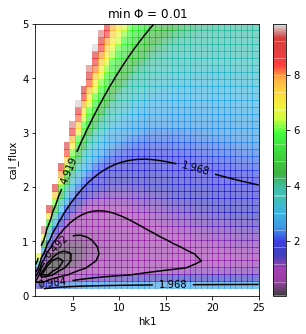

In [8]:
fig, ax = resurf.plot_response_surface(parnames=['hk1', 'cal_flux'], 
                             pstfile=pst_name, WORKING_DIR=working_dir,
                            nanthresh = 10);

## Let's evaluate the impact of Lambda on regression (regularization included)

In [9]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
# turn off the Maquardt lambda
inpst.pestpp_options['lambdas']=0.0
inpst.pestpp_options['lambda_scale_fac']=1.0

inpst.parameter_data.loc['fore_flux', 'partrans'] = 'fixed'
# set the starting values up in the corner of parameter space
inpst.parameter_data.loc['hk1', 'parval1'] = 20.0
inpst.parameter_data.loc['cal_flux', 'parval1'] = 4.0
inpst.control_data.noptmax=250
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.nolam.pst')))

In [10]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.', 'pestpp', 
                           pst_name.replace('.pst','.nolam.pst'), 
                           num_slaves=5, master_dir='.')
os.chdir("..")


master:pestpp k_wel_reg.nolam.pst /h :4004 in .
slave:pestpp k_wel_reg.nolam.pst /h localhost:4004 in ../slave_0
slave:pestpp k_wel_reg.nolam.pst /h localhost:4004 in ../slave_1
slave:pestpp k_wel_reg.nolam.pst /h localhost:4004 in ../slave_2
slave:pestpp k_wel_reg.nolam.pst /h localhost:4004 in ../slave_3
slave:pestpp k_wel_reg.nolam.pst /h localhost:4004 in ../slave_4


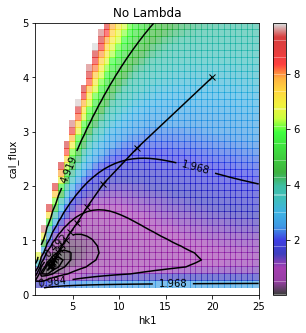

In [11]:
fig, ax = resurf.plot_response_surface(parnames=['hk1', 'cal_flux'], 
                             pstfile=pst_name, WORKING_DIR=working_dir,
                            nanthresh = 10);
pars, obfun = resurf.add_trajectory_to_plot(fig,ax, 'nolam','No Lambda', working_dir, pst_name)

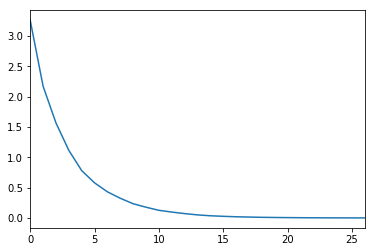

In [12]:
obfun.total_phi.plot()

# Let's try a small value `(1.0)` for Lambda

In [25]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name.replace('.nolam.pst','.lam1.0.pst')))
# set the Maquardt lambda to 1.0
inpst.pestpp_options['lambdas']=1.0
inpst.parameter_data.loc['hk1', 'parval1'] = 20.0
inpst.parameter_data.loc['cal_flux', 'parval1'] = 4.0
inpst.control_data.noptmax=250
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.lam1.0.pst')))

In [26]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.', 'pestpp', 
                           pst_name.replace('.pst','.lam1.0.pst'), 
                           num_slaves=5, master_dir='.')
os.chdir("..")

master:pestpp k_wel_reg.lam1.0.pst /h :4004 in .
slave:pestpp k_wel_reg.lam1.0.pst /h localhost:4004 in ../slave_0
slave:pestpp k_wel_reg.lam1.0.pst /h localhost:4004 in ../slave_1
slave:pestpp k_wel_reg.lam1.0.pst /h localhost:4004 in ../slave_2
slave:pestpp k_wel_reg.lam1.0.pst /h localhost:4004 in ../slave_3
slave:pestpp k_wel_reg.lam1.0.pst /h localhost:4004 in ../slave_4


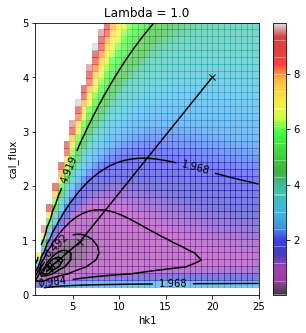

In [27]:
fig, ax = resurf.plot_response_surface(parnames=['hk1', 'cal_flux'], 
                             pstfile=pst_name, WORKING_DIR=working_dir,
                            nanthresh = 10);
pars, obfun = resurf.add_trajectory_to_plot(fig,ax, 'lam1.0','Lambda = 1.0', working_dir, pst_name)

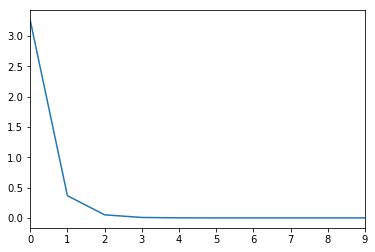

In [28]:
obfun.total_phi.plot()

# Let's try a really big value value `(50.0)` for Lambda

In [89]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name.replace('.nolam.pst','.lam50.0.pst')))
# set the Maquardt lambda to 1.0
inpst.pestpp_options['lambdas']=50.0
inpst.parameter_data.loc['hk1', 'parval1'] = 20.0
inpst.parameter_data.loc['cal_flux', 'parval1'] = 4.0
# let's make sure it keeps going even with tiny steps
inpst.control_data.noptmax=550
inpst.control_data.phiredstp=0.000001
inpst.control_data.relparstp=0.000001
inpst.control_data.nphistp=6
inpst.control_data.nrelpar=6
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.lam50.0.pst')))

In [90]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.', 'pestpp', 
                           pst_name.replace('.pst','.lam50.0.pst'), 
                           num_slaves=5, master_dir='.')
os.chdir("..")

master:pestpp k_wel_reg.lam50.0.pst /h :4004 in .
slave:pestpp k_wel_reg.lam50.0.pst /h localhost:4004 in ../slave_0
slave:pestpp k_wel_reg.lam50.0.pst /h localhost:4004 in ../slave_1
slave:pestpp k_wel_reg.lam50.0.pst /h localhost:4004 in ../slave_2
slave:pestpp k_wel_reg.lam50.0.pst /h localhost:4004 in ../slave_3
slave:pestpp k_wel_reg.lam50.0.pst /h localhost:4004 in ../slave_4


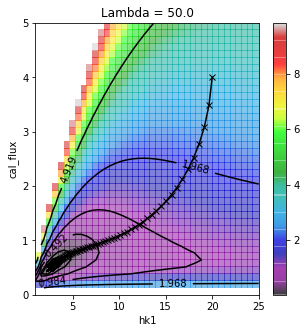

In [91]:
fig, ax = resurf.plot_response_surface(parnames=['hk1', 'cal_flux'], 
                             pstfile=pst_name, WORKING_DIR=working_dir,
                            nanthresh = 10);
pars, obfun = resurf.add_trajectory_to_plot(fig,ax, 'lam50.0','Lambda = 50.0', working_dir, pst_name)

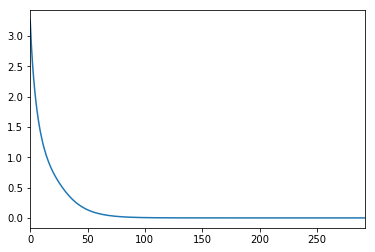

In [92]:
obfun.total_phi.plot()

In [94]:
pars.tail()

,iteration,hk1,cal_flux,fore_flux
288,288,2.50158,0.500065,1
289,289,2.50157,0.500061,1
290,290,2.50147,0.500078,1
291,291,2.50146,0.500072,1
292,292,2.50146,0.500068,1


In [96]:
obfun.tail()

,iteration,model_runs_completed,total_phi,measurement_phi,regularization_phi,obgnme,obgnme_pi
288,288,2587,1.281120e-08,1.281120e-08,0,0.000000,1.281120e-08
289,289,2596,1.011160e-06,1.011160e-06,0,0.000001,1.116180e-08
290,290,2605,1.816690e-08,1.816690e-08,0,0.000000,1.816690e-08
291,291,2614,1.583670e-08,1.583670e-08,0,0.000000,1.583670e-08
292,292,2623,1.380540e-08,1.380540e-08,0,0.000000,1.380540e-08
